<a href="https://colab.research.google.com/github/halizz821/DeepLearning_HSI_Classification/blob/main/VisionTransformer%20(ViT)%2B%202DCNN%5C2D_CNN_%2B_VisionTransformer_HSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mountin Google Drive

In [3]:
####### Mounting your google drive
from google.colab import drive
drive.mount('/content/drive')

####### Data address in google drive
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification
# %cd /content/drive/MyDrive/DeepLearning-HSI classification
# %cd /content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification


# Import Libraries

In [4]:
# !pip install earthpy
!pip install tqdm
import matplotlib.pyplot as plt

import numpy as np
# import earthpy.plot as ep
import seaborn as sns
# import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

In [5]:
## GLOBAL VARIABLES
windowSize = 21

# Functions

In [6]:
def ExtractPatches(img,GT=None, windowSize=3):
# This function divied the input image into patches making it ready for training your algorithm
# img: your image
# GT= your ground truth image. If you do not have any GT, just leave it
# windowSize: the size of each patch

  if GT is None:
        GT=np.ones_like(img[:,:,0]) # if the GT is not define, we create a dummy GT. In this case, you should ignore the output 'labels'

  margin = int((windowSize - 1) / 2) # margin to be added into your image
  img=np.pad(img, pad_width=((margin,margin),(margin,margin),(0,0)),mode='edge') # padding the input image according to the margin

  pos_in_image=np.asarray(np.where(GT!=0)).T # find the labled data in ground truth gt
  labels= GT[pos_in_image[:,0],pos_in_image[:,1]] #label of the samples

  ExtractedPatches=[]
  for i in pos_in_image:
    b=img[i[0]:i[0]+2*margin+1,i[1]:i[1]+2*margin+1,:] # extract patches
    ExtractedPatches.append(b)

  return np.asanyarray(ExtractedPatches), labels, pos_in_image
#######################################################################

def ScaleData(X,min_value,max_value):
  #This function sclae the data 'X' between 0 and 1
  min_value=np.float16(min_value)
  max_value=np.float16(max_value)
  X -= min_value
  X /= (max_value - min_value)
  return X

In [7]:
# Copyright 2021 Vittorio Mazzia. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# credits to https://www.tensorflow.org/tutorials/text/transformer
import tensorflow as tf
import copy

      # in our case, seq_len_q= i*i and depth= d_model, where i is the size of input image patches (e.g., for 16*16 patch, i=16),
      #  and d_model is the dimension of transformet model (the dimensio of first linera layer)

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    # (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True) #  transpose_b=True to transpose k

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32) # change the data type of dk to float32
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # scale attention according to the propsed method

    # add the mask to the scaled tensor.  # no mask is required for ViT, so can commented it
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)  #  axis=-1 apply softmax on the last diemsnion of input tensor

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


def position_wise_feed_forward_network(d_model, d_ff, activation):
  # Position-wise Feed-Forward Networks typically consist of two fully connected layers (MLP).
  # After the self-attention mechanism in the transformer processes the input, the output
  # goes through the Position-wise Feed-Forward Networks. Each position in the input
  # sequence is processed independently through these feed-forward networks.

  #arg:
  # d_model: dimention of model at the last dense layer. It equals to the dimention of ViT model
  # d_ff: dimension of the first dense layer
  # activaion: activation function for the dense model. Only one activiion is used between the two dense layers. In the original ViT paper, GELU was used as the activation

    return tf.keras.Sequential([
        # (batch_size, seq_len, dff)  seq_len in ViT equals i*i , where i is the size of input image patches (e.g., for 16*16 patch, i=16)
        tf.keras.layers.Dense(d_ff, activation=activation),
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class MultiHeadAttention(tf.keras.layers.Layer):
    # Multihead attention is a key component in many transformer-based models, especially in natural language processing tasks like machine translation,
    # text summarization, and language modeling. It allows the model to focus on different parts of the input sequence simultaneously,
    # capturing different types of information and improving its ability to handle long-range dependencies effectively.

    # The idea behind multihead attention is to split the input into multiple "heads," each of which learns different attention weights during training.
    # Each head is responsible for attending to different parts of the input sequence. After processing through their respective attention mechanisms,
    # the output of the heads is concatenated and linearly transformed to generate the final output of the attention layer.

    def __init__(self, d_model, num_heads, depth, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads # number of heads
        self.d_model = d_model     # dimension of ViT
        self.depth = depth         # depth of each head. it equals to d_model//num_heads. in the paper it is written as d_v or d_k

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        # In the context of multihead attention in transformer-based models, the split_heads function is used to reshape and split the input tensors into multiple "heads."
        # This operation is a crucial step in the multihead attention mechanism.
        # The purpose of splitting the input tensors into heads is to enable parallel processing of different parts of the input sequence.
        # Each head is responsible for attending to different parts of the input independently, allowing the model to capture different patterns and dependencies effectively.
        # The split_heads function reshapes the input tensor into a higher-dimensional tensor, where one of the dimensions is used to represent the heads.
        # After splitting the input into heads, attention is calculated independently for each head.

        x = tf.reshape(x, (batch_size, x.shape[1], self.num_heads, self.depth))   # reshape the input tensor x into a new shape (batch_size,  seq_len, num_heads, depth).

        x = tf.transpose(x, perm=[0, 2, 1, 3]) #reshaped tensor x to change the order of dimensions. The perm argument [0, 2, 1, 3] specifies the new order of dimensions.
        # x now e is (batch_size, num_heads, seq_len, depth)
        return x

    def get_config(self):
        config = {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth
        }
        base_config = super(MultiHeadAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)   # mask and attention_weights are not used in ViT
        scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, scaled_attention.shape[1], self.d_model))  # reshape the scaled_attention so that it has a similir dimention to the input, that is (batch_size, seq_len, d_model)

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights


class TransformerEncoderLayer(tf.keras.layers.Layer):

    # The code provided defines a single layer of the Transformer encoder, known as the TransformerEncoderLayer.
    # This layer contains several sub-layers, including multi-head self-attention and position-wise feed-forward networks.
    # It is designed to be stacked multiple times to form a complete Transformer encoder.

    def __init__(self, d_model, num_heads, d_ff, dropout, activation, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model        # dimension of ViT
        self.num_heads = num_heads    # number of heads in multihead attention layer of of ViT
        self.d_ff = d_ff              # dimension of the first dense layer in postionwise feed forward network
        self.dropout = dropout        # dropout rate
        self.activation = activation  # activiation to be used in postionwise feed forward network

        assert self.d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // self.num_heads

        self.mha = MultiHeadAttention(self.d_model, self.num_heads, self.depth)

        self.ffn = position_wise_feed_forward_network( self.d_model, self.d_ff, self.activation)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(self.dropout)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout)

    def get_config(self):
        config = {
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'd_ff': self.d_ff,
            'dropout': self.dropout,
            'activation': self.activation,
        }

        base_config = super(TransformerEncoderLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, training):

        attn_output, _ = self.mha(x, x, x, None) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  #residual connection (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) #residual connection (batch_size, input_seq_len, d_model)

        return out2


class TransformerEncoder(tf.keras.layers.Layer):

    # The provided code defines a custom Keras layer called TransformerEncoder, which is an implementation of the encoder stack in a Transformer model.
    # The TransformerEncoder consists of multiple stacked TransformerEncoderLayers, and each layer contains multihead self-attention and position-wise feed-forward networks.

    def __init__(self, d_model, num_heads, d_ff, dropout, activation, n_layers, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.n_layers = n_layers # number of transformer layers or blocks
        self.d_model= d_model
        self.num_heads= num_heads
        self.d_ff= d_ff
        self.dropout= dropout
        self.activation= activation


        self.encoder_layers = [TransformerEncoderLayer(self.d_model, self.num_heads, self.d_ff, self.dropout, self.activation) for i in range(self.n_layers)] # build transformers layers


    def get_config(self):
        config = {
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'd_ff': self.d_ff,
            'dropout': self.dropout,
            'activation': self.activation,
            'n_layers': self.n_layers
        }

        base_config = super(TransformerEncoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


    def call(self, x):
        for i in range(self.n_layers):
            x = self.encoder_layers[i](x)

        return x


class Patches(tf.keras.layers.Layer):

    # Defines a custom Keras layer called Patches, which is responsible for extracting patches from input images.
    # This layer is used as a preprocessing step in Vision Transformer (ViT) models to convert images into a sequence of patches before passing them through the transformer encoder stack.

    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def get_config(self):
        config = {
            'patch_size': self.patch_size
        }

        base_config = super(Patches, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, images):
        batch_size = tf.shape(images)[0]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # The output of tf.image.extract_patches will be a 4D tensor containing the extracted patches. The shape of the output tensor will depend on the input image size, patch size, and stride.
        # It will have the shape (batch_size, num_patches_height, num_patches_width, patch_size*patch_size*num_channels),
        # where num_patches_height and num_patches_width represent the number of patches extracted along the height and width dimensions of the input image, respectively.
        # The last dimension represents the flattened version of the patch, with the size patch_size*patch_size*num_channels.


        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size ,patches.shape[1]*patches.shape[2], patch_dims]) # reshape patches to have a size of (batchsize, total num of patches (=seq_len), size of flatten patch)
        return patches


class PatchClassEmbedding(tf.keras.layers.Layer):

    # defines a custom Keras layer called PatchClassEmbedding, which is used in Vision Transformer (ViT) models to add class token embeddings and positional embeddings to the input patches.

    def __init__(self, d_model, n_patches, kernel_initializer='he_normal', **kwargs):
        super(PatchClassEmbedding, self).__init__(**kwargs)

        self.d_model = d_model # dimension of ViT (i.e., dimesndion of first dense layer in ViT)
        self.n_patches=n_patches
        self.n_tot_patches = self.n_patches + 1 # it added one patch because of the extra lernable class toekn
        self.kernel_initializer = kernel_initializer # initilaizer for class embedding
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

        self.class_embed = self.add_weight(shape=(1, 1, self.d_model), initializer=self.kernel_initializer, name="class_token")  # extra learnable class
        # The above line is responsible for creating and initializing the learnable weights for the class token embedding. This class token embedding is an additional embedding added to the input patches
        # and represents global information for the entire image. It is used to capture high-level features or context that apply to the entire input image.


        self.position_embedding = tf.keras.layers.Embedding( input_dim=(self.n_tot_patches), output_dim=self.d_model )
        # The above line is used to create an Embedding layer within the PatchClassEmbedding custom Keras layer.
        # The Embedding layer is responsible for mapping integer indices (positions) to dense vectors (positional embeddings) of a specified dimension (d_model).
        # It is a fundamental part of the Transformer model and Vision Transformer (ViT) to provide positional information to the model.

    def get_config(self):
        config = {
            'd_model': self.d_model,
            'n_patches': self.n_patches,
            # 'n_tot_patches': self.n_tot_patches,
            'kernel_initializer': self.kernel_initializer
        }
        base_config = super(PatchClassEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
       #  shape pf inputs (batch_size, num_patches, d_model)

        positions = tf.range(start=0, limit=self.n_tot_patches, delta=1) # This line generates a tensor positions representing the positions of each patch in the input sequence. containing integers from 0 to self.n_tot_patches - 1.

        #  shape pf x (batch_size, num_patches, d_model)
        x = tf.repeat(self.class_embed, tf.shape(inputs)[0], axis=0) # This line repeats the class token embedding self.class_embed for each example in the batch. x now has a shpae similar to the input (Batchsize, seq_len, d_model )

        #  shape pf x (batch_size, num_patches + 1, d_model)
        x = tf.concat((x, inputs), axis=1) # This line concatenates the class token embedding (x) with the input patches (inputs) along the second dimension (axis=1).

        encoded = x + self.position_embedding(positions) # This line adds the positional embeddings to the concatenated tensor x with broadcasting.
        # The self.position_embedding layer takes the integer positions as input and returns dense vectors (positional embeddings) of shape (batch_size, num_patches + 1, d_model)
        # the shape of position_embedding(positions)  (num_patches + 1, d_model) is not agree with x (batch_size, num_patches + 1, d_model). It is done through broadcasting
        # Broadcasting allows the addition to be performed element-wise with each positional embedding added to the corresponding patch in x.
        # encoded is a tensor of shape (batch_size, num_patches + 1, d_model) where each patch now has an associated positional embedding.
        return encoded

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=20000.0):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, dtype='float32')
        self.warmup_steps = warmup_steps

    def get_config(self):
        config = {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
        }

        return config

    def __call__(self, step):
        step = tf.cast(step, dtype='float32')
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Load Data

In [9]:
################## X data (145, 145, 200)   Hyperspectral satellite   (145*145, 200)
data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected'].astype(np.float16)


###################### Y data (labels)
gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (145, 145)
Number of Bands: 200


In [10]:
# ################## X data (1096, 715, 102)   Hyperspectral satellite   (1096*715, 102)
# data = loadmat('Pavia.mat')['pavia'].astype(np.float16)


# ###################### Y data (labels)
# gt = loadmat('Pavia_gt.mat')['pavia_gt']

# print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

# Data Visualization

*This section of code is not necessary and you can skip it. It just visuallizes some spectral bands of the input image to get familiar with your data*

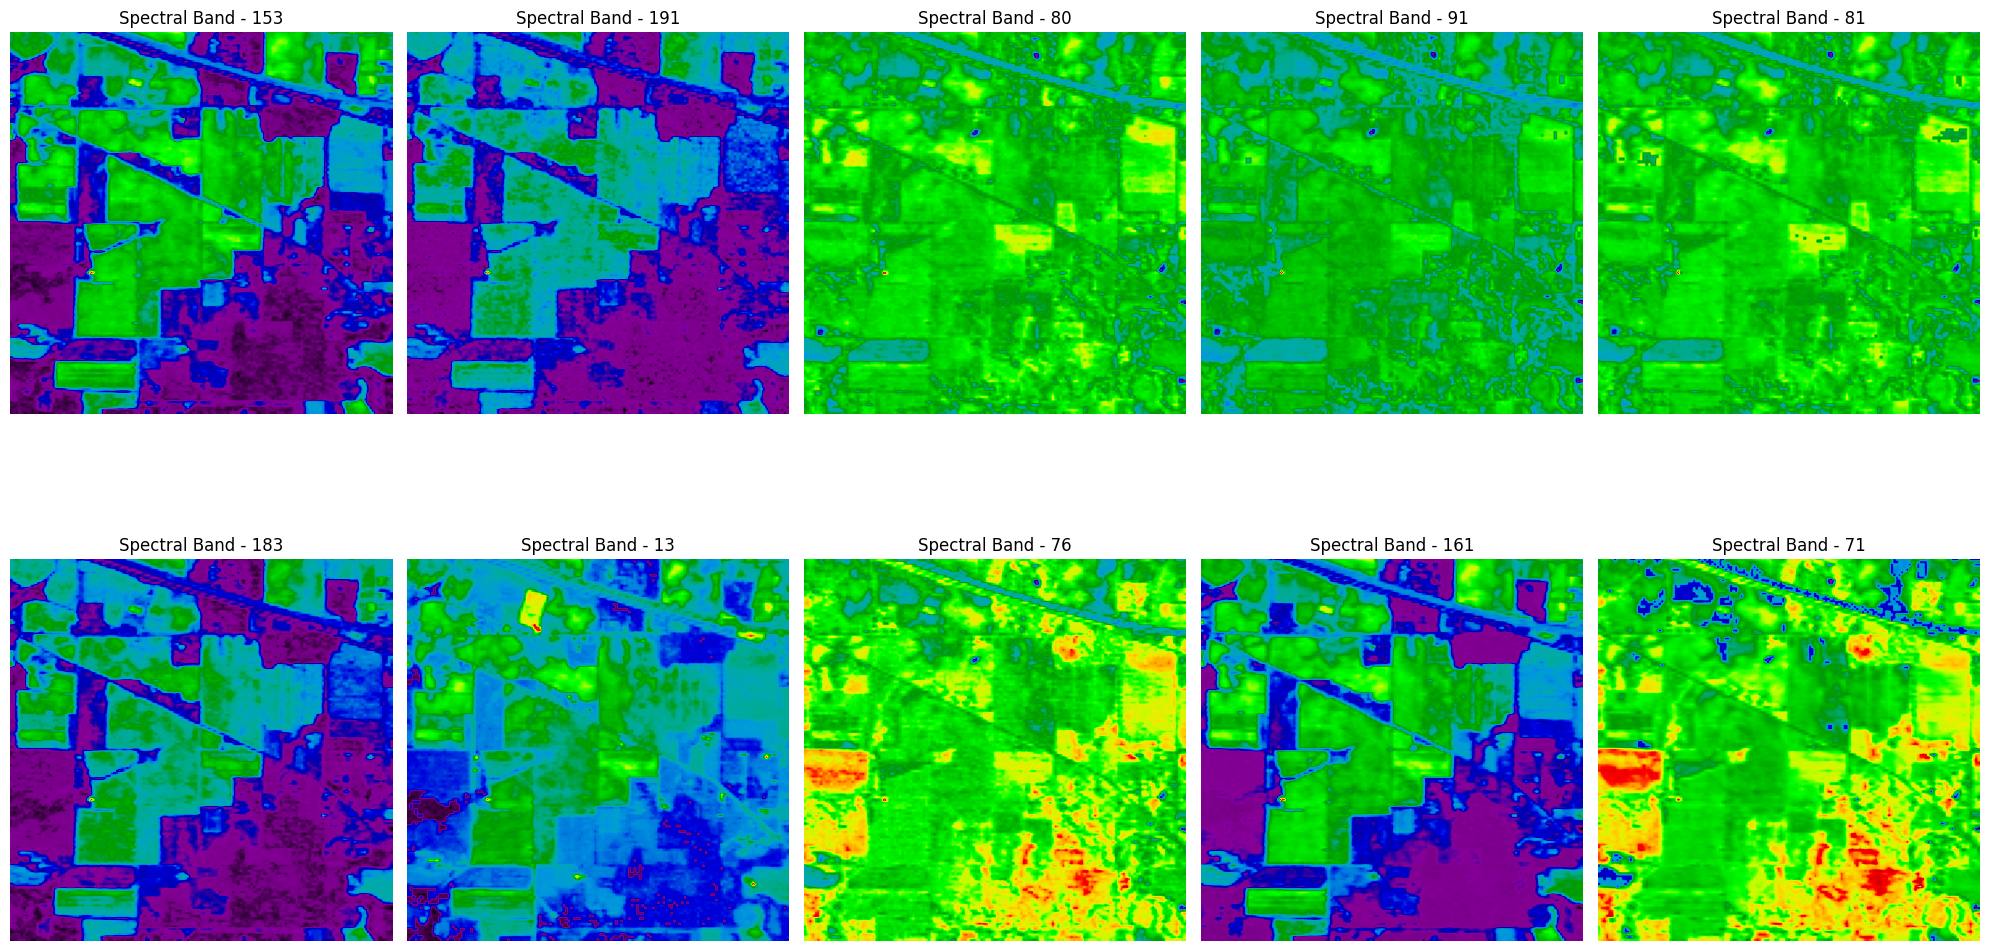

In [ ]:
fig = plt.figure(figsize = (20, 12))  # open a figure

ax = fig.subplots(2, 5) # divide the figure into several subfigures

##### plot each subplot
for i in range(2):
  for j in range(5):
    c = np.random.randint(data.shape[2]) ### randomely select a spectral band
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Spectral Band - {c}") # title
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Visualization

*This section of code is not necessary and you can skip it. It just visuallizes an RGB color composite of the input image to get familiar with your data*

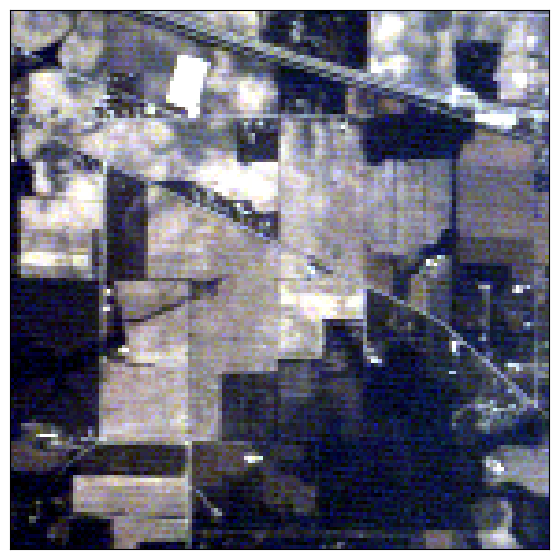

In [ ]:
mdata = np.moveaxis(data, -1, 0) # becauase mdata in ep.plot_rgb shoould be An n-dimensional array in rasterio band order (bands, rows, columns) containing the layers to plot.
R=10 # Red spectral band number
G=5 # Green spectral band number
B=2  # Blue spectral band number
ep.plot_rgb(mdata, (R,G,B), figsize=(7, 7),stretch=True)  # Plot red, green, and blue bands, respectively

plt.show()

# GroundTruth Visualizaation

*This section of code is not necessary and you can skip it. It just visuallizes your ground truth to get more familiar with your data*

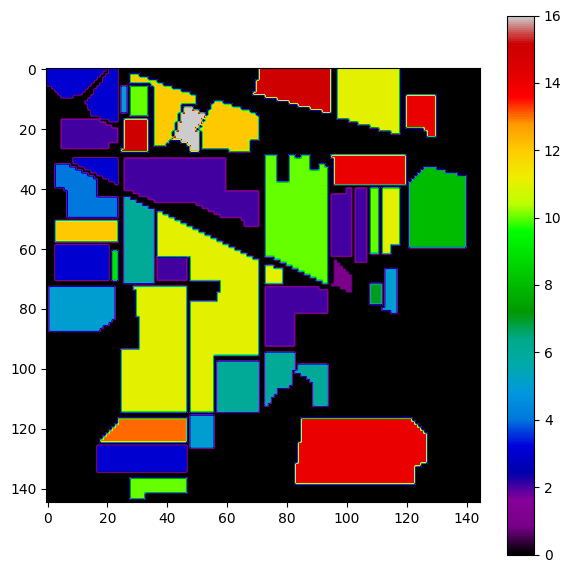

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(7, 7)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(gt)

# Pre-processing
This step includes:

  1) Extract patches of the image

  2) Encode labels of each class

  3) Split samples into training, validation and test samples

  4) Scaling samples to [0,1] interval

In [11]:

################# Extract patches of the the image
X, labels, pos_in_image = ExtractPatches(data,GT=gt, windowSize=windowSize)

################# Encode labels of each class

enc = OneHotEncoder()
y=enc.fit_transform(labels.reshape(-1, 1)).toarray() #turn labels to categorical (i.e., each label is represented by a vector) usig  OneHotEncoder method

################# Split samples into: 1) Training, 2) Validation and 3) Test samples

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    train_size=0.8)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_validation: {X_val.shape}\ny_validation: {y_val.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

################ Scaling

# Find the minimum and maximum values of the array
min_value = np.min(X_train)
max_value = np.max(X_train)

# Scale the array between 0 and 1
X_train=ScaleData(X_train,min_value,max_value)
X_val=ScaleData(X_val,min_value,max_value)
X_test=ScaleData(X_test,min_value,max_value)



X_train: (6559, 21, 21, 200)
y_train: (6559, 16)
X_validation: (1640, 21, 21, 200)
y_validation: (1640, 16)
X_test: (2050, 21, 21, 200)
y_test: (2050, 16)


# Build ViT

In [12]:
# dataset configurations
input_size = X_train[0].shape                       # input shape of ViT model  e.g.(21,21,200)
patch_size = 7                                      # e.g. for patch_size=7, the patches dimension is(7*7)
num_patches = (input_size[0] // patch_size) ** 2    # total num of patches
out_size = y_train.shape[1]                         # output shape of model


In [13]:
# model configurations
d_model = 44  # dimension of ViT (i.e., dimesndion of first dense layer in ViT)
d_ff = d_model * 2 # dimension of the first dense layer in postionwise feed forward network
n_heads = 4    # number of heads in multihead attention layer of of ViT
mlp_head_size = 64 # dimension of the last MLP layer after the transformer encoder
dropout = 0.4 # dropout rate
activation = tf.nn.gelu  # activiation to be used in postionwise feed forward network
n_layers = 3   # number of tranformer encoder layers



In [14]:
# pre-process layers
pre_process_pipeline = tf.keras.Sequential([
        # tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        # tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.03),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.3, width_factor=0.3),], name="pre_process_pipeline")


In [15]:
def CNN2D(input):
  conv_layer1 = Conv2D(filters=64, kernel_size=(3,3), activation='LeakyReLU',padding='same')(input)

  conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), activation='LeakyReLU',padding='same')(conv_layer1)
  conv_layer2 = Dropout(0.4)(conv_layer2)
  # conv_layer2 =MaxPooling2D(pool_size=(2, 2),padding='same')(conv_layer2)
  conv_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer2)

  return conv_layer2


In [16]:
def build_vit(transformer):
    # Input
    inputs = tf.keras.layers.Input(shape=input_size)

    # Data pre_processing Pipeline
    # x = pre_process_pipeline(inputs)

    cnn = CNN2D(inputs)

    # Patch Creation
    x = Patches(patch_size)(cnn)

    # Linear Projection of Flattened Patches
    x = tf.keras.layers.Dense(d_model)(x)

    # Position Embedding + Extra learnable class embedding
    x = PatchClassEmbedding(d_model, num_patches)(x)

    # Transformer Model
    x = transformer(x)

    # Take only the Extra Learnable Class
    x = tf.keras.layers.Lambda(lambda x: x[:,0,:])(x)

    # MLP Head
    x = tf.keras.layers.Dense(mlp_head_size)(x)

    outputs = tf.keras.layers.Dense(out_size, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)

In [17]:
transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout,
                                 activation, n_layers)

In [18]:
vit_model = build_vit(transformer)
vit_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 21, 200)]     0         
                                                                 
 conv2d (Conv2D)             (None, 21, 21, 64)        115264    
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 dropout_6 (Dropout)         (None, 21, 21, 32)        0         
                                                                 
 layer_normalization_6 (Laye  (None, 21, 21, 32)       64        
 rNormalization)                                                 
                                                                 
 patches (Patches)           (None, 9, 1568)           0         
                                                             

# Train ViT model

In [19]:



lr = CustomSchedule(d_model, warmup_steps=20000.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

######## compiling the model
vit_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

######## define calback of the model
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'ViT_Model.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True,
                              ) # save the model with the best loss performance on validation data

# tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

########## Fit the model on training samples
hist = vit_model.fit(X_train,
                       y_train,
                       epochs = 30, #No of epochs
                       batch_size = 32, # batch size
                       validation_data = (X_val, y_val), # validation data
                       callbacks=[early_stop,
                                  checkpoint])


Epoch 1/30
205/205 [==============================] - 47s 59ms/step - loss: 2.1757 - accuracy: 0.2842 - val_loss: 1.8531 - val_accuracy: 0.3762
Epoch 2/30
205/205 [==============================] - 7s 36ms/step - loss: 1.8166 - accuracy: 0.3716 - val_loss: 1.6472 - val_accuracy: 0.3945
Epoch 3/30
205/205 [==============================] - 10s 50ms/step - loss: 1.6990 - accuracy: 0.4049 - val_loss: 1.7056 - val_accuracy: 0.3811
Epoch 4/30
205/205 [==============================] - 10s 48ms/step - loss: 1.6011 - accuracy: 0.4211 - val_loss: 1.7658 - val_accuracy: 0.4061
Epoch 5/30
205/205 [==============================] - 8s 37ms/step - loss: 1.5234 - accuracy: 0.4514 - val_loss: 1.4730 - val_accuracy: 0.4835
Epoch 6/30
205/205 [==============================] - 8s 39ms/step - loss: 1.4511 - accuracy: 0.4746 - val_loss: 1.8719 - val_accuracy: 0.3494
Epoch 7/30
205/205 [==============================] - 7s 35ms/step - loss: 1.7278 - accuracy: 0.3941 - val_loss: 1.8324 - val_accuracy: 0.3

# Plot results (loss and accuracy) of all epochs

In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir SA_logs/

In [20]:
hist = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

# Validate the performance of the model

65/65 [==============================] - 3s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.92      0.69      0.79       380
           2       0.90      0.81      0.85       185
           3       0.98      0.77      0.86        60
           4       0.48      0.85      0.62        55
           5       0.94      0.88      0.91       156
           6       0.40      0.29      0.33         7
           7       0.98      0.90      0.94       104
           8       0.00      0.00      0.00         0
           9       0.41      0.78      0.54       102
          10       0.90      0.86      0.88       517
          11       0.60      0.82      0.69        87
          12       1.00      0.98      0.99        42
          13       0.95      0.90      0.92       266
          14       0.83      0.91      0.87        70
          15       0.47      0.90      0.62        10

    accuracy                           0.83      2050
   macro avg       0.71   

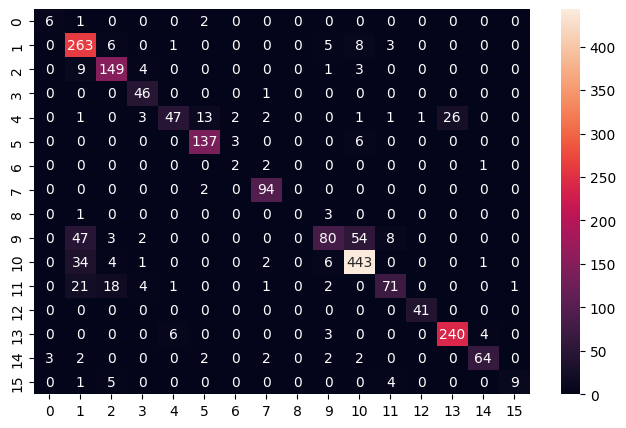

In [21]:
######## load the model with the best performance on validation samples
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'Patches': Patches,
                          'PatchClassEmbedding': PatchClassEmbedding,
                          'HeNormal': tf.keras.initializers.HeNormal,
                          'TransformerEncoder': TransformerEncoder}):
    model = load_model("ViT_Model.h5")

########## Results on test samples

pred = np.argmax(model.predict(X_test), axis=1) # predic for the the test samples

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1)))

from sklearn.metrics import *
Kappa=cohen_kappa_score(np.argmax(y_test, 1),pred) # calculate Kappa coefficient
OA=accuracy_score(np.argmax(y_test, 1),pred) # calculate Overall accuracy
matrix = confusion_matrix(np.argmax(y_test, 1),pred) # calculate confusion matrix
Producer_accuracy= matrix.diagonal()/matrix.sum(axis=1) # calculate producer accuracy

print(f"Overall Accuracy: {OA*100}\nKappa coefficient: {Kappa}\nProducer accuracy: {Producer_accuracy*100} ")

# plot confusion matrix in a heatmap
plt.figure(figsize = (8,5))
df_cm = pd.DataFrame(matrix)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

######## delet unncessary varialbe to empty RAM
del pred, X_test, X_train, X_val, y, y_test, y_train, y_val


# Predicting whole image

In [ ]:

########## scale the image patches
X -= min_value
den=np.float16(max_value - min_value)
X /= den
####################

prediction = np.argmax(model.predict(X), axis=1) # predict each pathce's class

classifed_img=np.zeros((145,145))

classifed_img[pos_in_image[:,0], pos_in_image[:,1]]=prediction

######## Plot the classified image
def plot_data(data):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(classifed_img)

# If your RAM has no room for predicting lables for the whole image:

No Biggie. Just uncomment the two block of codes below and follow the below steps:

First, run the first cell below.

Then, restard the runtime, and reconnect your Google Drive

Next, run all the defined classes and functions in section called 'Functions'

Finially, run the second cell below.

In [ ]:
# X,_,pos_in_image= ExtractPatches(data, GT=gt, windowSize=windowSize) #patches the image

########## scale the image patches
X -= min_value
den=np.float16(max_value - min_value)
X /= den
####################

np.savez('X.npz', array1=X, array2=pos_in_image)


Processing Chunks:   0%|          | 0/10 [00:00<?, ?it/s]

32/32 [==============================] - 7s 71ms/step


Processing Chunks:  10%|█         | 1/10 [00:13<01:58, 13.13s/it]

32/32 [==============================] - 2s 64ms/step


Processing Chunks:  20%|██        | 2/10 [00:17<01:05,  8.19s/it]

32/32 [==============================] - 3s 87ms/step


Processing Chunks:  30%|███       | 3/10 [00:21<00:44,  6.31s/it]

32/32 [==============================] - 1s 17ms/step


Processing Chunks:  40%|████      | 4/10 [00:23<00:26,  4.45s/it]

32/32 [==============================] - 1s 30ms/step


Processing Chunks:  50%|█████     | 5/10 [00:25<00:17,  3.58s/it]

32/32 [==============================] - 4s 113ms/step


Processing Chunks:  60%|██████    | 6/10 [00:30<00:15,  3.91s/it]

32/32 [==============================] - 1s 40ms/step


Processing Chunks:  70%|███████   | 7/10 [00:32<00:10,  3.38s/it]

32/32 [==============================] - 2s 58ms/step


Processing Chunks:  80%|████████  | 8/10 [00:35<00:06,  3.42s/it]

32/32 [==============================] - 1s 23ms/step


Processing Chunks:  90%|█████████ | 9/10 [00:38<00:03,  3.15s/it]

32/32 [==============================] - 1s 35ms/step


Processing Chunks: 100%|██████████| 10/10 [00:40<00:00,  2.88s/it]

8/8 [==============================] - 2s 231ms/step


Processing Chunks: 11it [00:42,  3.89s/it]


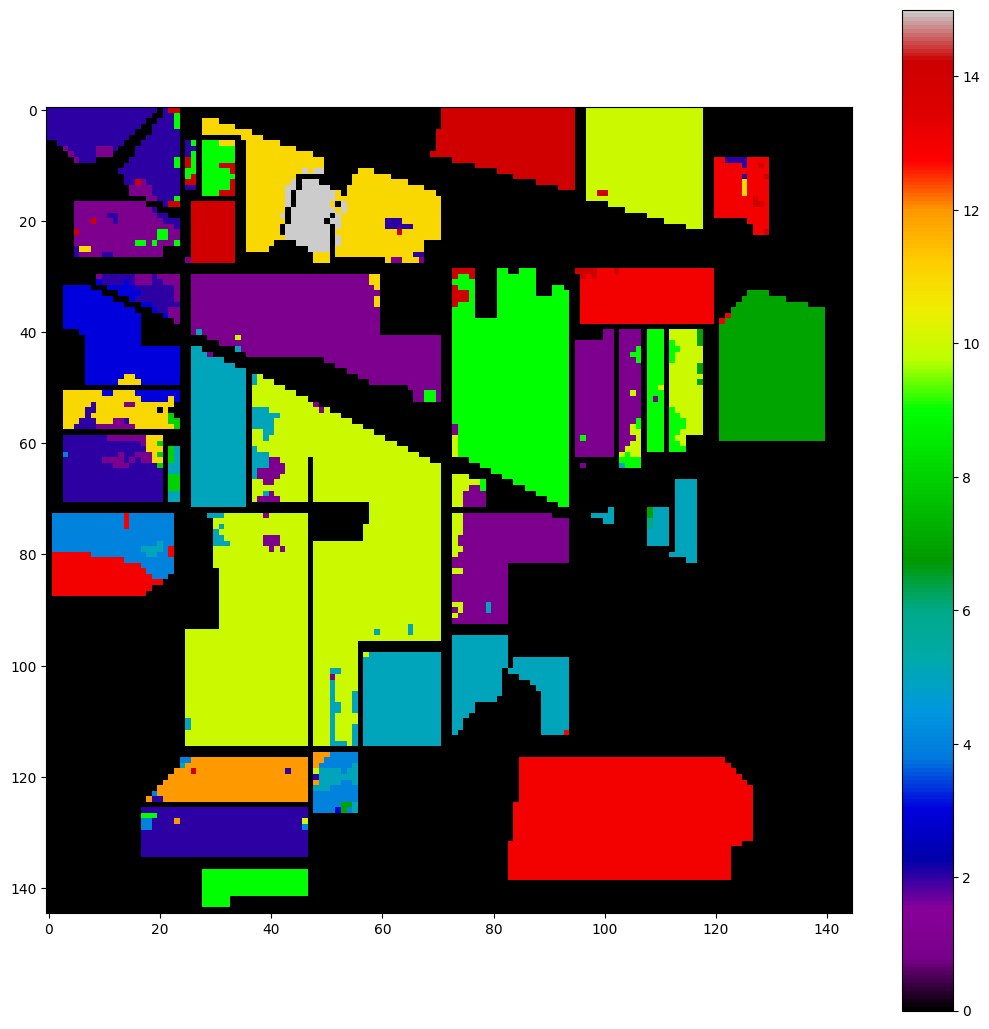

In [ ]:
from tqdm import tqdm
import numpy as np



loaded_data = np.load('X.npz') # reload the saved data
X = loaded_data['array1']
pos_in_image = loaded_data['array2']

# Define the chunk size
chunk_size = 1000  # Adjust this based on your available memory

# Define a generator function to yield data chunks
def data_chunk_generator(data, chunk_size):
    num_samples = data.shape[0]
    for start in range(0, num_samples, chunk_size):
        end = start + chunk_size
        yield data[start:end]

# Load your trained model
######## load the model with the best performance on validation samples
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'Patches': Patches,            # for this linw of code you need to import the defined classes in the bigining of this code
                          'PatchClassEmbedding': PatchClassEmbedding,
                          'HeNormal': tf.keras.initializers.HeNormal,
                          'TransformerEncoder': TransformerEncoder}):
    model = load_model("ViT_Model.h5")

# Create a loop to process chunks of data and save results
Per=[]

for chunk in tqdm(data_chunk_generator(X, chunk_size), total= (X.shape[0]//chunk_size), desc="Processing Chunks"):
    prediction = np.argmax(model.predict(chunk), axis=1) # predict each pathce's class
    Per.append(prediction)
    # Save or process predictions for the current chunk as needed


result_array = np.hstack(Per)

classifed_img=np.zeros((145,145))

classifed_img[pos_in_image[:,0], pos_in_image[:,1]]=result_array

######## Plot the classified image
def plot_data(data):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(classifed_img)